In [21]:
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import sys
%matplotlib inline
sns.set()

In [22]:
data = loadmat('ex4data1.mat')
weights = loadmat('ex4weights.mat')
x = data['X']
y = (np.zeros(50000)).reshape(5000, 10)
theta1 = np.array(weights['Theta1'])
theta2 = np.array(weights['Theta2'])

In [23]:
for number in range(0, 10):
    if number == 0:
        y[0:500, 9:] = 1
    else:
        y[number * 500:(number + 1) * 500, number - 1:number] = 1

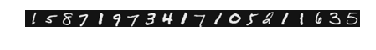

In [24]:
sample = np.random.choice(x.shape[0], 20)
plt.imshow(x[sample, :].reshape(-1, 20).T, cmap='gray')
plt.axis('off');

In [25]:
def sigmoidFunction (z):
    return 1 / (1 + np.exp(-z))

In [26]:
def hypothesisFunction (x, theta1, theta2):
    a1 = np.c_[np.ones((data['X'].shape[0], 1)), x]
    z2 = np.dot(a1, theta1.T)
    
    a2 = np.c_[np.ones((data['X'].shape[0], 1)), sigmoidFunction(z2)]
    z3 = np.dot(a2, theta2.T)
    
    a3 = sigmoidFunction(z3)
    return dict([('a3', a3), ('z2', z2), ('a2', a2)])

In [27]:
def costFunction (y, hypothesisFunction):
    m = y.shape[0]
    j = (1 / m) * (np.log(hypothesisFunction).T.dot(-y) - np.log(1 - hypothesisFunction).T.dot(1 - y))
    costs = []
    for number in range(10):
        costs.append(j[number, number])
    mainCosts = np.array(costs)
    return mainCosts

In [28]:
costFunction (y, hypothesisFunction(x, theta1, theta2)['a3'])

array([ 0.02115448,  0.03022682,  0.03946314,  0.02972325,  0.02998443,
        0.02026629,  0.028228  ,  0.03474724,  0.03946383,  0.0143717 ])

In [29]:
def regularizedCostFunction (costs, theta1, theta2, λ):
    m = y.shape[0]
    costs += ((λ / (2 * m)) * (np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:]))))
    return costs

In [30]:
def sigmoidGradient (z):
    return sigmoidFunction(z) * (1 - sigmoidFunction(z))

In [31]:
randomTheta1 = np.random.uniform(low = -0.12, high = 0.12, size = (25, 400))
randomTheta2 = np.random.uniform(low = -0.12, high = 0.12, size = (10, 25))

In [32]:
def backPropagationFunction (y, hypothesisFunction, theta2):
    m = y.shape[0]
    a3 = hypothesisFunction (x, theta1, theta2)['a3']
    z2 = hypothesisFunction (x, theta1, theta2)['z2']
    a2 = hypothesisFunction (x, theta1, theta2)['a2']
    𝛿3 = a3 - y
    𝛿2 = np.dot(𝛿3, theta2)[:, 1:] * sigmoidGradient(z2)
    Δ2 = np.dot(a2.T, 𝛿3)
    D2 = 1 / m * Δ2
    return D2

In [44]:
def computeNumericalGradient (theta1, theta2, ϵ):
    f = []
    epsilonVector1 = np.zeros((25, 401))
    for number1 in epsilonVector1:
        number1 += ϵ
        theta1Plus = theta1 + epsilonVector1
        theta1Minus = theta1 - epsilonVector1
        jPlus = costFunction (y, hypothesisFunction(x, theta1Plus, theta2)['a3'])
        jMinus = costFunction (y, hypothesisFunction(x, theta1Minus, theta2)['a3'])
        f.append((jPlus + jMinus) / 2)
        number1 -= ϵ
    epsilonVector2 = np.zeros((10, 26))
    for number2 in epsilonVector2:
        number2 += ϵ
        theta2Plus = theta2 + epsilonVector2
        theta2Minus = theta2 - epsilonVector2
        jPlus = costFunction (y, hypothesisFunction(x, theta1, theta2Plus)['a3'])
        jMinus = costFunction (y, hypothesisFunction(x, theta1, theta2Minus)['a3'])
        f.append((jPlus + jMinus) / 2)
        number2 -= ϵ
    return np.array(f)

In [45]:
print(computeNumericalGradient(theta1, theta2, 10 ** -4).shape)

(10, 10)
